# Text Classification with RoBERTa



In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [56]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 16
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

#  Load the dataset

In [57]:
df = pd.read_csv('/kaggle/input/combine-dataset/model_ready_combined.csv')
df.head()

,clean training,label
0,as a woman you shouldn t complain about cleani...,0
1,boy dats cold tyga dwn bad for cuffin dat hoe ...,1
2,dawg you ever fuck a bitch and she start to cr...,1
3,she look like a tranny,1
4,the shit you hear about me might be true or it...,1


In [58]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [59]:
X_data = df[['clean training']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

# Tokenize & encode

In [60]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [61]:
# Split into train and validation , test datasets

X_train1, X_test, y_train1, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=777) # random_state to reproduce results


X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1 , test_size=0.2, random_state=777)

In [62]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [63]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)
X_val = roberta_encode(X_val, tokenizer)
y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')
y_val = np.asarray(y_val, dtype='int32')

## Create RoBERTa model

In [64]:
def build_model(n_categories):
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        return model

In [65]:
model = build_model(3)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_3 (TFRobertaMo ((None, 256, 768), ( 124645632   input_word_ids[0][0]             
____________________________________________________________________________________________

In [66]:
#create callback
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

## Train model



In [68]:
history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_val,y_val))

Epoch 1/3
6094/6094 [==============================] - 3373s 553ms/step - loss: 0.3695 - accuracy: 0.8397 - val_loss: 0.3978 - val_accuracy: 0.8316
Epoch 2/3
6094/6094 [==============================] - 3370s 553ms/step - loss: 0.3007 - accuracy: 0.8673 - val_loss: 0.4133 - val_accuracy: 0.8278
Epoch 3/3
6094/6094 [==============================] - 3370s 553ms/step - loss: 0.2471 - accuracy: 0.8900 - val_loss: 0.4116 - val_accuracy: 0.8340


In [76]:
model.save('my_model.h5')

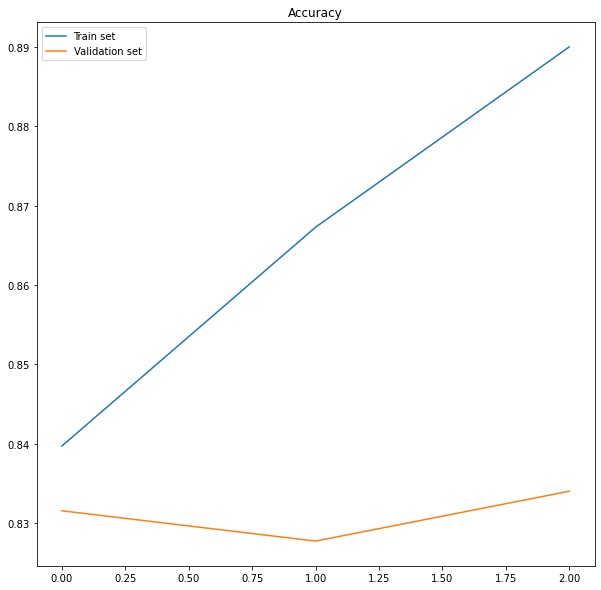

In [69]:

plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [70]:
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [71]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 83.39%


In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      9723
           1       0.87      0.78      0.82     10429
           2       0.75      0.83      0.79     10314

    accuracy                           0.83     30466
   macro avg       0.84      0.84      0.84     30466
weighted avg       0.84      0.83      0.83     30466



Text(0.5, 69.0, 'Predicted label')

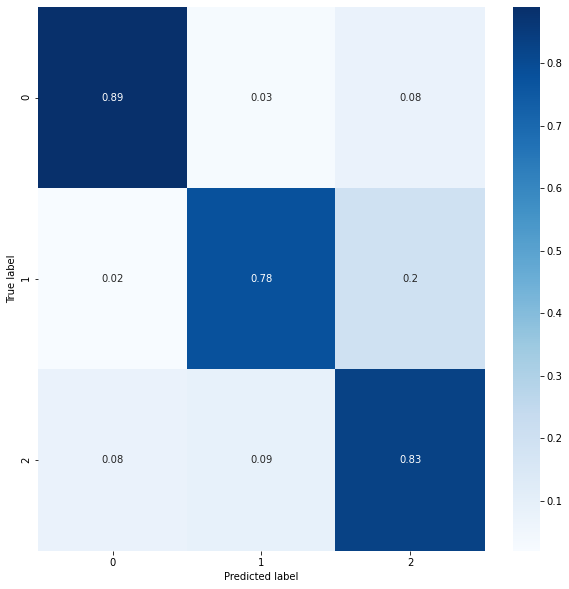

In [73]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
label_names = list(range(len(con_mat_norm)))

con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')